<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 2: Variational Autoencoders
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [37]:
name = 'AmirHossein Naghdi'
std_id = '400102169'

In [38]:
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt

import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [40]:
# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cpu device


# Dataset (5 points)

Download the MNIST dataset and merge the train and test datasets for training the generative model.

In [41]:
transform = transforms.Compose([
    transforms.ToTensor(),  # This scales pixel values to [0, 1]
])

# Load train and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Merge the two datasets to train the model on the images.

In [42]:
merged_dataset = ConcatDataset([train_dataset, test_dataset])
batch_size = 64
merged_loader = DataLoader(merged_dataset, batch_size=batch_size, shuffle=True)

# Print the size of the merged dataset
print(f'The size of the merged dataset is {len(merged_loader.dataset)}')

The size of the merged dataset is 70000


# EDA (10 points)

Plot the distribution of each class in the dataset.

In [43]:
def plot_class_distribution(dataloader):
    # Initialize a dictionary to count occurrences of each class (0-9)
    class_counts = {i: 0 for i in range(10)}

    # Iterate through the DataLoader to count the labels
    for _, labels in dataloader:
        for label in labels:
            class_counts[label.item()] += 1

    # Plot the histogram
    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values(), color='b')
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.title("Distribution of Each Class in the Dataset")
    plt.xticks(range(10))
    plt.show()

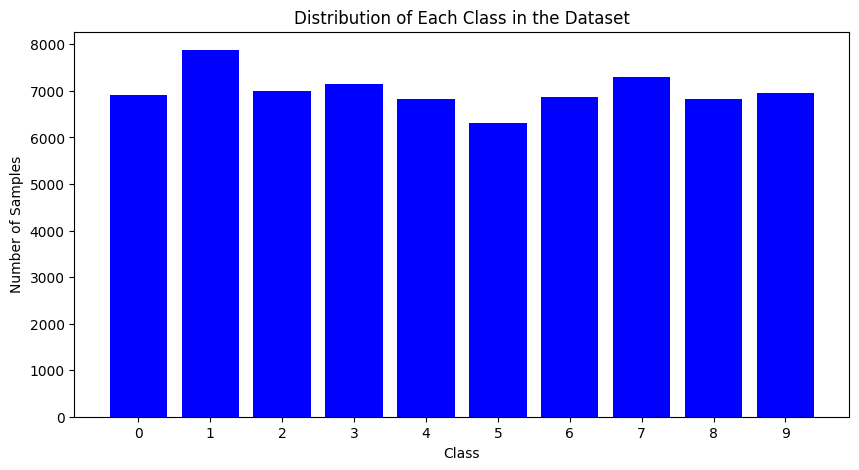

In [44]:
plot_class_distribution(merged_loader)

Plot the average of each class in the dataset.

In [45]:
def plot_class_averages(dataloader):
    # Initialize tensors to accumulate sums and counts for each class
    class_sums = {i: torch.zeros((28, 28)) for i in range(10)}
    class_counts = {i: 0 for i in range(10)}

    # Iterate over the DataLoader to accumulate sums and counts for each class
    for images, labels in dataloader:
        for img, label in zip(images, labels):
            class_sums[label.item()] += img.squeeze(0)  # Remove channel dimension
            class_counts[label.item()] += 1

    # Calculate and plot the average image for each class
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        avg_image = class_sums[i] / class_counts[i]
        ax.imshow(avg_image, cmap='gray')
        ax.set_title(f"Class {i}")
        ax.axis('off')

    plt.suptitle("Average Image for Each Class")
    plt.show()

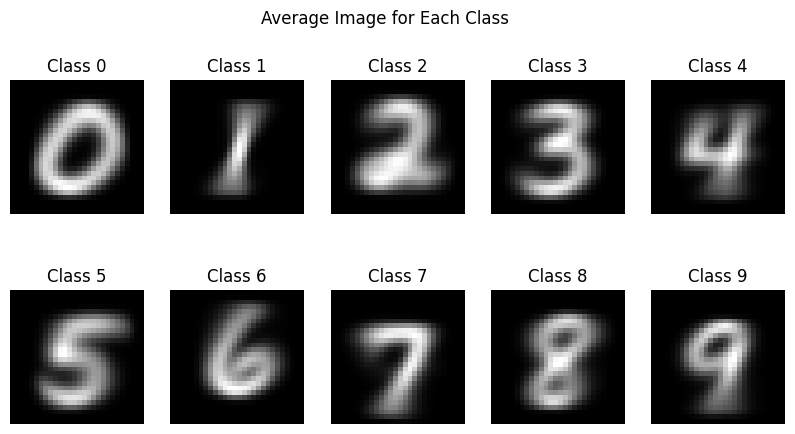

In [46]:
plot_class_averages(merged_loader)

# Variational Autoencoder (25 points)

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class VAE(nn.Module):
    def __init__(self, x_dim=784, h_dim1=512, h_dim2=256, z_dim=2):
        super(VAE, self).__init__()

        # Encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)  # Mean
        self.fc32 = nn.Linear(h_dim2, z_dim)  # Log variance

        # Decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)  # mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)  # Return z sample

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h))  # Use torch.sigmoid instead of F.sigmoid

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))  # Flatten the input
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# Initialize the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []

# Training (20 points)

Define the loss function for training the VAE. The loss functions should be a combination of the reconstruction loss and the KL-divergence loss. You can choose to increase the weight of these losses to achieve better results.

In [48]:
def loss_function(x, x_hat, mean, log_var):
    # Ensure x_hat is in the range [0, 1]
    x_hat = torch.clamp(x_hat, 0, 1)  # Clamp values to prevent issues

    # Reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(x_hat, x.view(-1, 784), reduction='sum')

    # KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reconstruction_loss + kl_divergence


Now you must train your network using the loss function you defined earlier. Make sure to plot and monitor the training loss over epochs.

In [49]:
def plot_losses(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()

def train(model, optimizer, dataloader, n_epochs=50):
    model.train()
    all_losses = []
    for epoch in range(n_epochs):
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            x = batch[0].to(device)  # Move data to device
            x_hat, mu, log_var = model(x)
            loss = loss_function(x, x_hat, mu, log_var)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader.dataset)
        all_losses.append(avg_loss)
        print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {avg_loss:.4f}')

    return all_losses


In [50]:
torch.cuda.is_available()

False

Epoch 1/50, Loss: 170.7182
Epoch 2/50, Loss: 152.2213
Epoch 3/50, Loss: 148.3237
Epoch 4/50, Loss: 146.0137
Epoch 5/50, Loss: 144.4592
Epoch 6/50, Loss: 143.5238
Epoch 7/50, Loss: 142.6048
Epoch 8/50, Loss: 141.8343
Epoch 9/50, Loss: 141.3902
Epoch 10/50, Loss: 140.9849
Epoch 11/50, Loss: 140.3793
Epoch 12/50, Loss: 140.2109
Epoch 13/50, Loss: 139.8706
Epoch 14/50, Loss: 139.4747
Epoch 15/50, Loss: 139.3146
Epoch 16/50, Loss: 138.9676
Epoch 17/50, Loss: 138.8066
Epoch 18/50, Loss: 138.4839
Epoch 19/50, Loss: 138.1840
Epoch 20/50, Loss: 138.2302
Epoch 21/50, Loss: 137.7304
Epoch 22/50, Loss: 137.4771
Epoch 23/50, Loss: 137.3348
Epoch 24/50, Loss: 137.1980
Epoch 25/50, Loss: 136.9452
Epoch 26/50, Loss: 136.9001
Epoch 27/50, Loss: 137.1081
Epoch 28/50, Loss: 136.7621
Epoch 29/50, Loss: 136.8896
Epoch 30/50, Loss: 136.4689
Epoch 31/50, Loss: 136.3852
Epoch 32/50, Loss: 136.1318
Epoch 33/50, Loss: 136.1746
Epoch 34/50, Loss: 136.0539
Epoch 35/50, Loss: 135.9681
Epoch 36/50, Loss: 135.8113
E

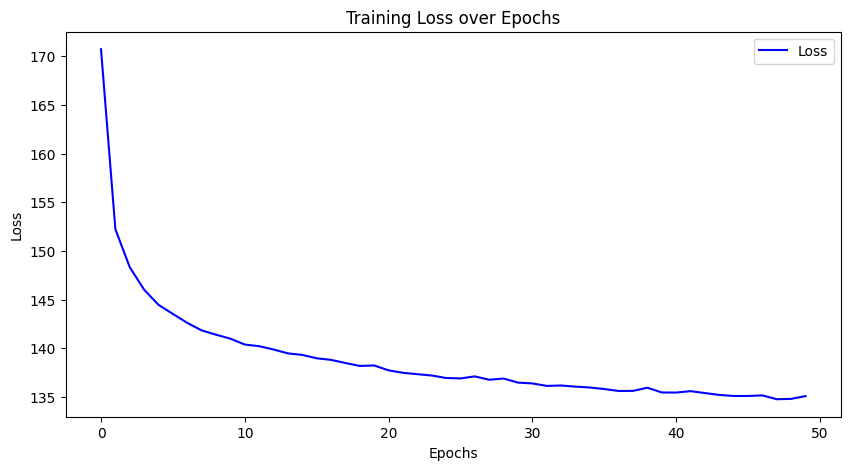

In [51]:
losses += train(model, optimizer, merged_loader, n_epochs=50)
plot_losses(losses)

# The Encoder (20 points)

Let's first take a look at the encoder. Start by visualizing the latent dimension for the merged dataset.

In [59]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(vae, dataloader, batch_count=30, title='Latent Space Visualization'):
    vae.eval()
    all_mu = []
    all_labels = []

    # Collect latent vectors and labels
    for i, (images, labels) in enumerate(dataloader):
        if i >= batch_count:
            break
        images = images.view(-1, 784).to(device)  # Flatten and move to device
        with torch.no_grad():
            mu, _ = vae.encoder(images)
        all_mu.append(mu.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    # Convert lists to arrays
    all_mu = np.concatenate(all_mu)
    all_labels = np.concatenate(all_labels)

    # Plot the latent space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(all_mu[:, 0], all_mu[:, 1], c=all_labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter, label='Digit Class')
    plt.title(title)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()


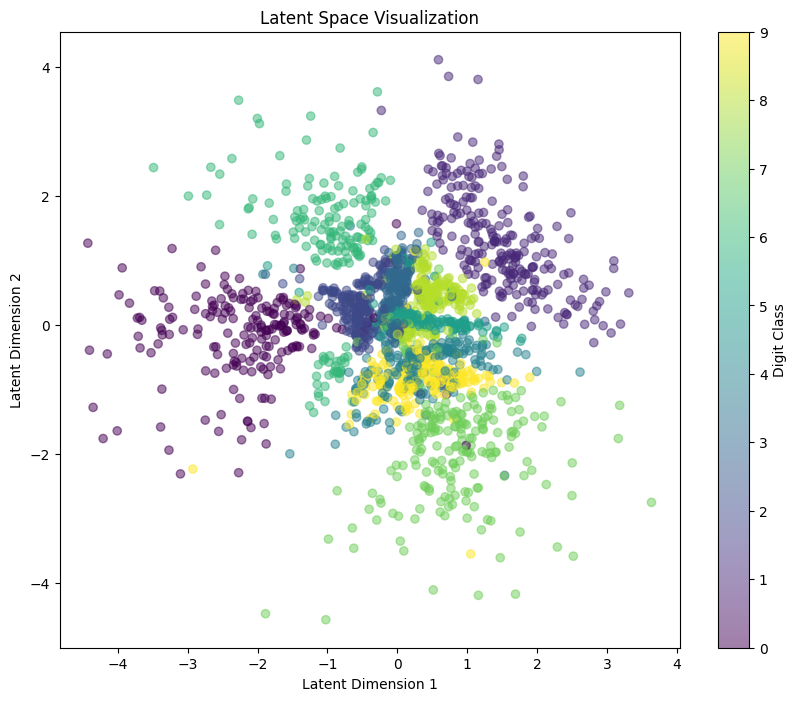

In [60]:
visualize(model, merged_loader)

Imagine if the input data for the encoder followed a very different distribution. Invert the images in the original datset and plot the latent dimension once more to show the difference.

In [61]:

def inverted_visualize(vae, dataloader, batch_count=30, title='Latent Space Visualization'):
    vae.eval()
    all_mu = []
    all_labels = []

    # Collect latent vectors and labels for inverted images
    for i, (images, labels) in enumerate(dataloader):
        if i >= batch_count:
            break
        images = (1 - images).view(-1, 784).to(device)  # Invert and flatten
        with torch.no_grad():
            mu, _ = vae.encoder(images)
        all_mu.append(mu.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    # Convert lists to arrays
    all_mu = np.concatenate(all_mu)
    all_labels = np.concatenate(all_labels)

    # Plot the latent space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(all_mu[:, 0], all_mu[:, 1], c=all_labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter, label='Digit Class')
    plt.title(title)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()

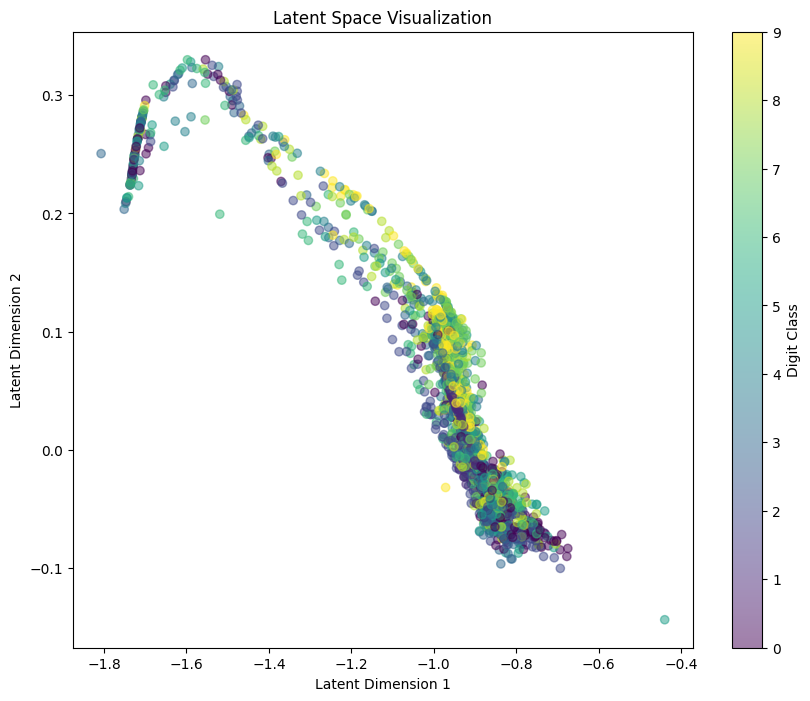

In [62]:
inverted_visualize(model, merged_loader)

Explain how the difference in the latent dimension allows us to detect data samples that don't follow the original distribution. How can this difference be used for anomaly detection? If we had used an autoencoder instead, what would be our observation then?

*`Your Answer:`*

# The Decoder (20 points)

In this section we are going to test the properties of the decoder. First implement a function to create samples based on the input mean and variance.

In [63]:
def generate_digit(mean, var):
    std = torch.sqrt(var)
    z = torch.randn_like(std) * std + mean  # Sample from N(mean, var)
    with torch.no_grad():
        generated_image = vae.decoder(z.to(device))
    return generated_image.view(28, 28).cpu().numpy()


Now using this function plot the decoded output sampled from a uniform distribution from -1 to +1.

In [64]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]]).float().to(device)
            with torch.no_grad():
                generated_image = model.decoder(z_sample).view(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = generated_image.cpu().numpy()

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap='gray')
    plt.title("Latent Space Decoded Images")
    plt.axis('off')
    plt.show()


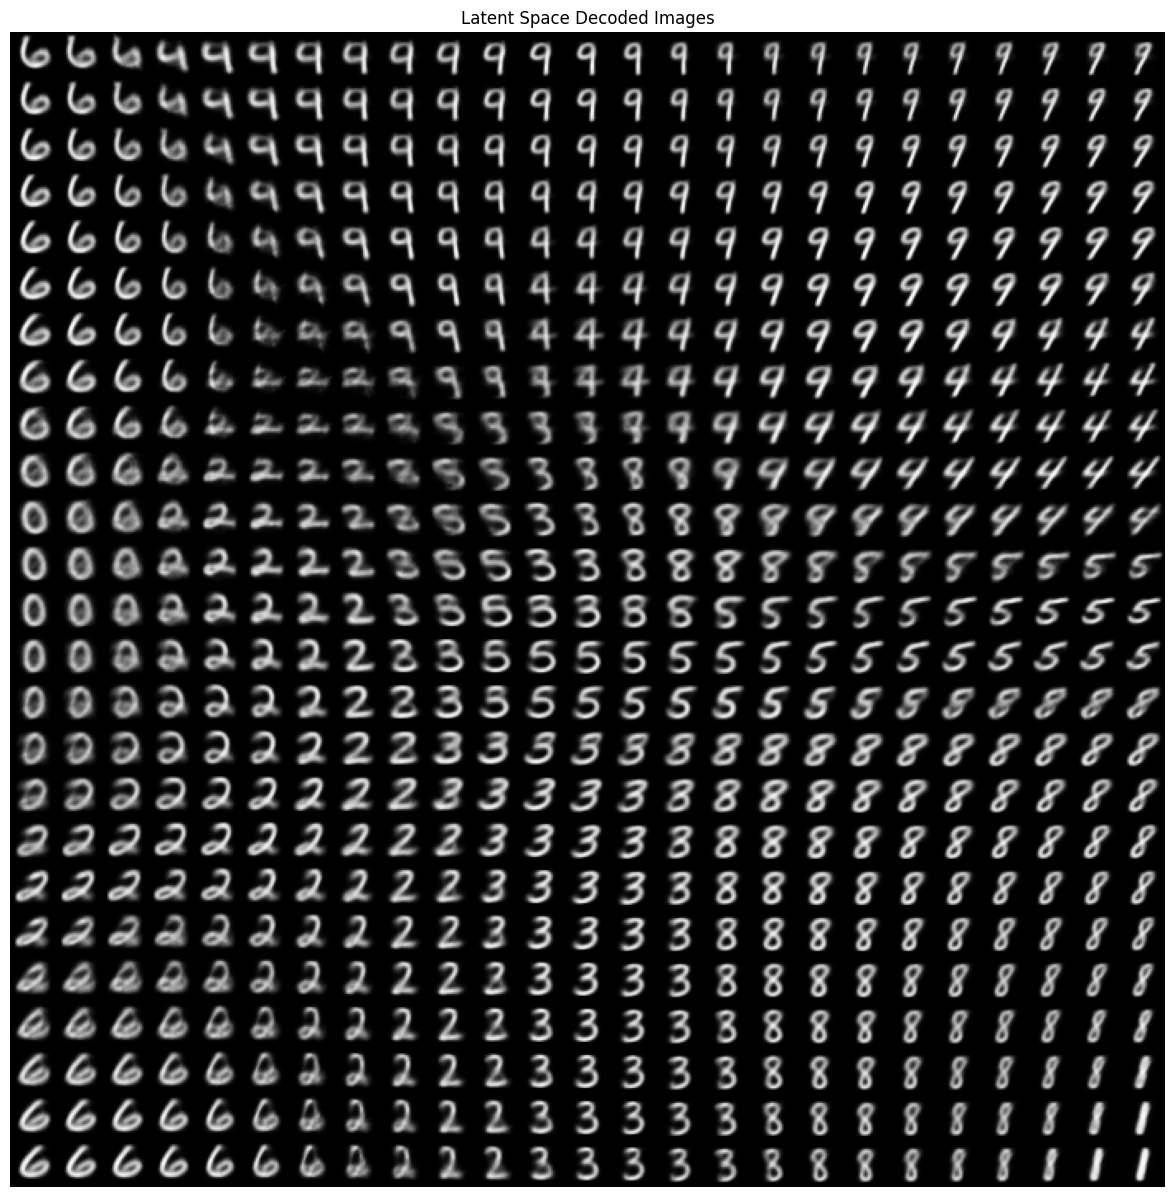

In [65]:
plot_latent_space(model)

What happens when you sample from regions outside the aformentioned space? Why? What could we expect if the network was not a variational autoencoder, but a simple autoencoder instead?

*`Your Answer:`*